In [196]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

In [197]:
f= h5py.File('Data1.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # this gives the set of parameters that characterize the galaxy 
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    

f.close()

In [198]:
print('image',image.shape)
print('cat',cat.shape)
print('label',label.shape)
print('snr',snr.shape)
print('sigma',sigma.shape)
print('image_nonoise',image_nonoise.shape)
print('image_withnoise',image_withnoise.shape)

image (18779, 64, 64)
cat (18779, 6, 64, 64)
label (18779, 5)
snr (18779,)
sigma (18779,)
image_nonoise (18779, 64, 64)
image_withnoise (18779, 64, 64)


In [199]:
get_elip1 = lambda g1,g2 : - (1+g1**2+g2**2-2*np.sqrt(g1**2+g2**2))/(-1+g1**2+g2**2)
get_elip2 = lambda g1,g2 : - (1+g1**2+g2**2+2*np.sqrt(g1**2+g2**2))/(-1+g1**2+g2**2)
get_theta = lambda g1,g2 : np.arctan2(-g1,-g2)

In [200]:
f=0.9

all_inds = np.linspace(0,len(label)-1,len(label)).astype(int)
train_inds = np.random.randint(0,len(label)-1,int(len(label)*f))
test_inds = np.setdiff1d(all_inds,train_inds)

In [201]:
train_nonoise = image_nonoise[train_inds]
test_nonoise = image_nonoise[test_inds]
train_noise = image_withnoise[train_inds]
test_noise = image_nonoise[test_inds]
train_label = label[train_inds]
test_label = label[test_inds]
train_snr = snr[train_inds]
test_snr = snr[test_inds]

In [202]:
train_flux = train_label[:,0]
test_flux = test_label[:,0]
train_index = train_label[:,1]
test_index = test_label[:,1]
train_rad = train_label[:,2]
test_rad = test_label[:,2]
train_g1 = train_label[:,3]
test_g1 = test_label[:,3]
train_g2 = train_label[:,4]
test_g2 = test_label[:,4]
train_ellip = get_elip1(train_g1,train_g2)
test_ellip = get_elip1(test_g1,test_g2)
train_theta = get_theta(train_g1,train_g2)
test_theta = get_theta(test_g1,test_g2)

# Flux Model

Text(0.5, 1.0, 'Centre')

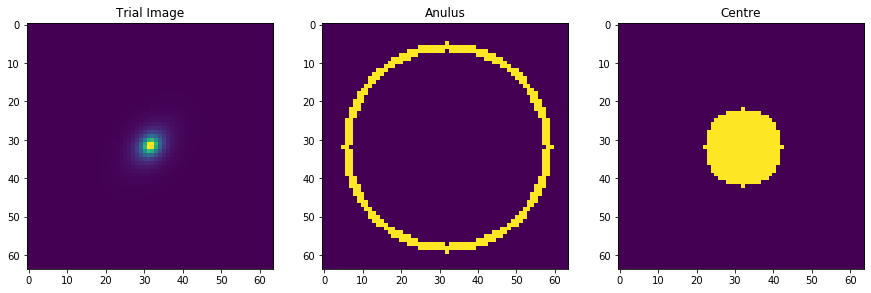

In [9]:
def getanulus(r2,r3):
    y,x = np.ogrid[-32:64-32, -32:64-32]
    mask2 = x**2 + y**2 <= r2**2
    mask3 = x**2 + y**2 <= r3**2
    array = np.zeros((64, 64)) 
    array[mask3] = 1
    array[mask2] = 0
    return array

def getcentre(r1):
    y,x = np.ogrid[-32:64-32, -32:64-32]
    mask1 = x**2 + y**2 <= r1**2
    array = np.zeros((64, 64)) 
    array[mask1] = 1
    return array

r1,r2,r3= 10,25,27
anulus = getanulus(r2,r3)
centre = getcentre(r1)

fig, ax = plt.subplots(ncols=3,figsize=(15,5))

ax[0].imshow(train_nonoise[0])
ax[0].set_title("Trial Image")
ax[1].imshow(anulus)
ax[1].set_title("Anulus")
ax[2].imshow(centre)
ax[2].set_title("Centre")

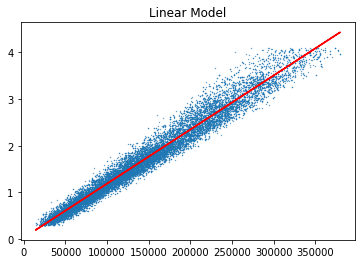

In [13]:
#train on noisy data
sky_per_pixel = np.sum((train_noise*anulus),(1,2))/(np.sum(anulus))
tots = np.sum((train_noise*centre),(1,2)) - np.sum(centre)*sky_per_pixel

model = np.polyfit(tots,train_flux,1)
plt.scatter(tots,train_flux,s=0.1)
plt.plot(tots,np.polyval(model,tots),c='r')
plt.title("Linear Model")

#make predictions
sky_per_pixel = np.sum((test_noise*anulus),(1,2))/(np.sum(anulus))
tots = np.sum((test_noise*centre),(1,2)) - np.sum(centre)*sky_per_pixel
pred_flux = np.polyval(model,tots)

(0, 4.5)

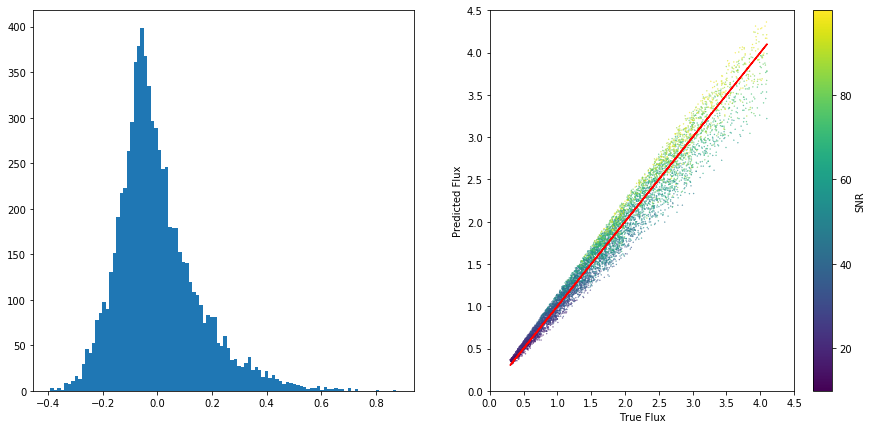

In [14]:
fig,ax = plt.subplots(ncols=2,figsize=(15,7))
sc = ax[1].scatter(test_flux,pred_flux,s=0.1,c=test_snr)
err = test_flux - pred_flux
plt.colorbar(sc,label='SNR')

ax[0].hist(err,bins=100)

ax[1].plot(test_flux,test_flux,c='r')
ax[1].set_xlabel("True Flux")
ax[1].set_ylabel("Predicted Flux")
ax[1].set_xlim(0,4.5)
ax[1].set_ylim(0,4.5)

Text(0.5, 0, 'angle')

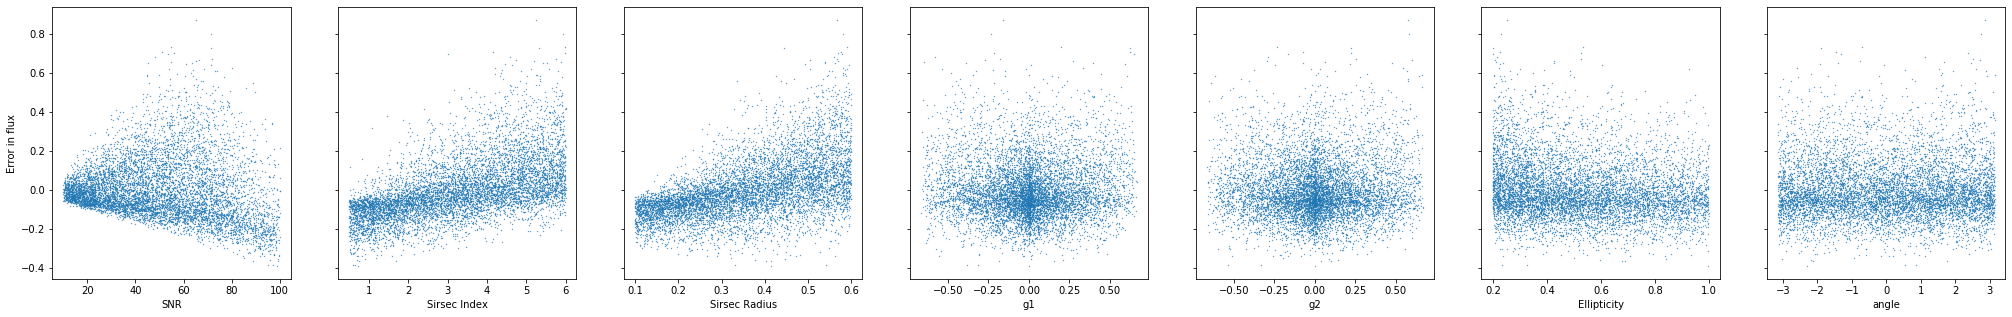

In [15]:
fig,ax = plt.subplots(ncols=7,figsize=(35,5),sharey=True)

ax[0].scatter(test_snr,err,s=0.1)
ax[0].set_xlabel("SNR")
ax[0].set_ylabel("Error in flux")

ax[1].scatter(test_index,err,s=0.1)
ax[1].set_xlabel("Sirsec Index")

ax[2].scatter(test_rad,err,s=0.1)
ax[2].set_xlabel("Sirsec Radius")

ax[3].scatter(test_g1,err,s=0.1)
ax[3].set_xlabel("g1")

ax[4].scatter(test_g2,err,s=0.1)
ax[4].set_xlabel("g2")

ax[5].scatter(test_ellip,err,s=0.1)
ax[5].set_xlabel("Ellipticity")

ax[6].scatter(test_theta,err,s=0.1)
ax[6].set_xlabel("angle")


## g1 and g2 model:

In [67]:
#modified from stackoverflow: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

def twoD_Gaussian2(coords, sigma_x, sigma_y, theta):
    #Setting a bunch of parameters, speeds up the fitting!
    xo=31.5
    yo=31.5
    offset=0.0
    amplitude=1.0
    (x, y) = coords
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

def fit_gaussian(nimg):
    img = nimg/np.max(nimg)

    x = np.linspace(0, 63, 64)
    y = np.linspace(0, 63, 64)
    x, y = np.meshgrid(x, y)
    #first three parameters are set, the others I guess at 0
    initial_guess = (3.5,3.5,np.pi/2)
    bounds = [[0,0,0],[7,7,np.pi]]
    popt, pcov = curve_fit(twoD_Gaussian2, (x, y), img.flatten(), p0=initial_guess,bounds=bounds)
    data_fitted = twoD_Gaussian2((x, y), *popt)

    sigx = popt[0]
    sigy = popt[1]
    theta = popt[2]
    #minor over major axis
    guess_elip = np.min([sigx,sigy])/np.max([sigx,sigy])
    return theta,guess_elip

## Look at rotations for the gaussian:

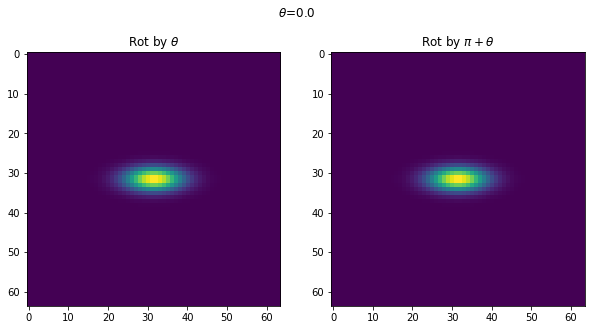

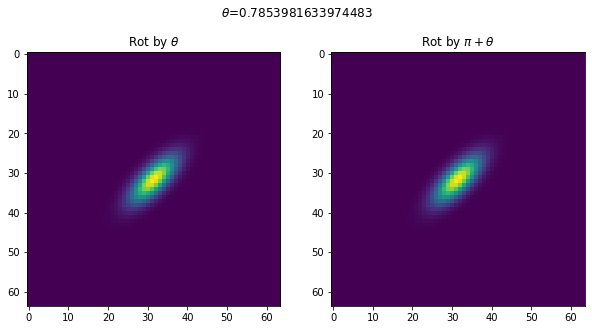

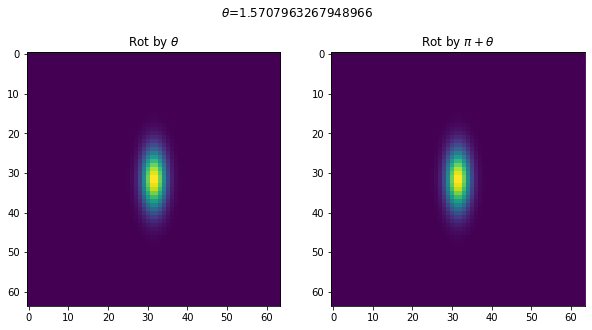

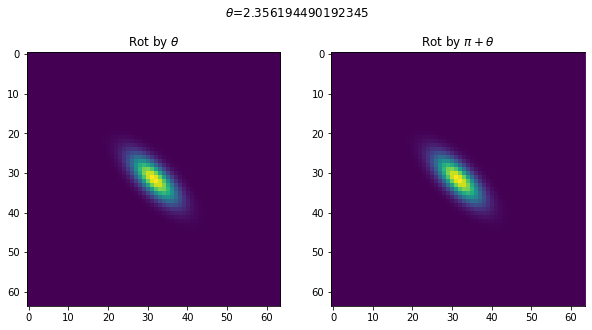

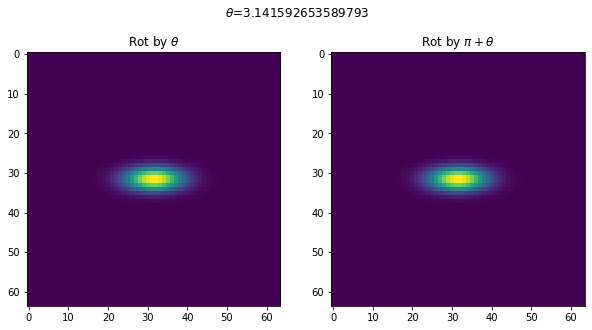

In [68]:
x = np.linspace(0, 63, 64)
y = np.linspace(0, 63, 64)
x, y = np.meshgrid(x, y)

thetas = np.linspace(0,np.pi,5)
for theta in thetas:
    fig,ax = plt.subplots(ncols=2,figsize=(10,5))
    data_fitted = twoD_Gaussian2((x, y), 5,2,theta)
    ax[0].imshow(data_fitted.reshape(64, 64))
    ax[0].set_title(r"Rot by $\theta$")
    data_fitted = twoD_Gaussian2((x, y), 5,2,np.pi+theta)
    ax[1].imshow(data_fitted.reshape(64, 64))
    ax[1].set_title(r"Rot by $\pi + \theta$")
    plt.suptitle(r'$\theta$='+str(theta))
    plt.show()

### Now do the same for the images

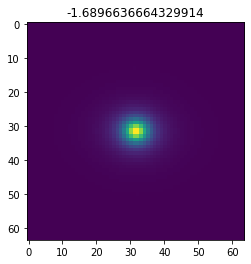

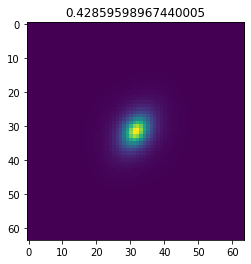

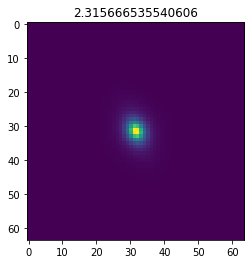

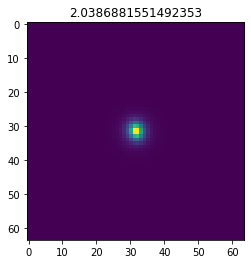

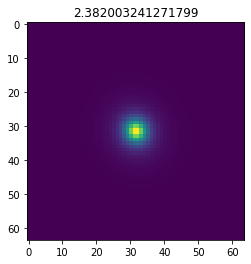

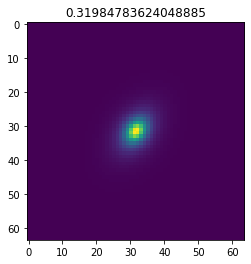

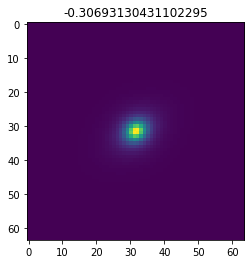

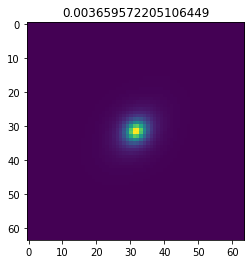

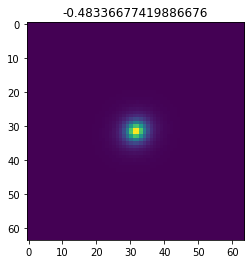

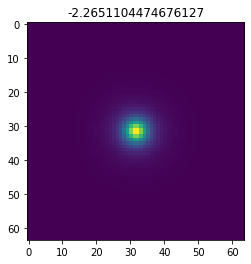

In [69]:
rand_inds = np.random.randint(0,len(train_nonoise)-1,10)
for ind in rand_inds:
    plt.imshow(train_nonoise[ind])
    plt.title(train_theta[ind])
    plt.show()

## We take advantage of normalization to reduce parameter space. 

[1.78395676 2.66648911 1.94467619]


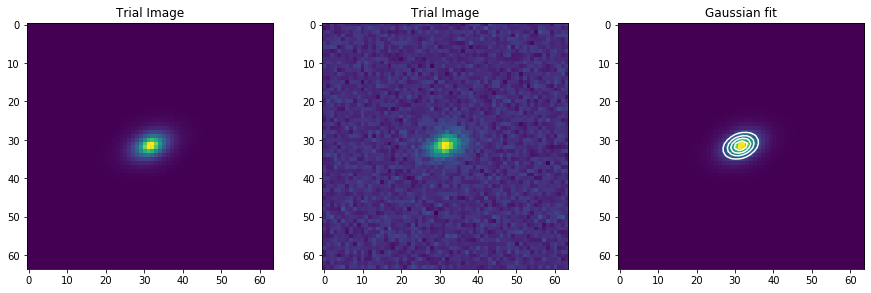

In [108]:
fig, ax = plt.subplots(ncols=3,figsize=(15,5))


img = train_nonoise[5]/np.max(train_nonoise[5])
x = np.linspace(0, 63, 64)
y = np.linspace(0, 63, 64)
x, y = np.meshgrid(x, y)
#first three parameters are set, the others I guess at 0
initial_guess = (3.5,3.5,np.pi/2)
bounds = [[0,0,-np.pi],[7,7,np.pi]]
popt, pcov = curve_fit(twoD_Gaussian2, (x, y), img.flatten(), p0=initial_guess,bounds=bounds)
data_fitted = twoD_Gaussian2((x, y), *popt)

ax[0].imshow(img)
ax[0].set_title("Trial Image")
ax[1].imshow(train_noise[5])
ax[1].set_title("Trial Image")
ax[2].imshow(img)
ax[2].contour(x, y, data_fitted.reshape(64, 64), 4, colors='w')
ax[2].set_title("Gaussian fit")
print(popt)
#print(train_)

In [189]:
#fit to train
out = []
for i in range(len(train_noise)):
    out.append(fit_gaussian(train_noise[i]))
out = np.asarray(out)
pred_thetas = out.T[0]
pred_ellips = out.T[1]
model = np.polyfit(pred_ellips,train_ellip,3)
pred2_ellips = np.polyval(ellip_model,pred_ellips)

In [208]:
#predict on test
out = []
for i in range(len(test_noise)):
    out.append(fit_gaussian(test_noise[i]))
out = np.asarray(out)
pred_thetas = out.T[0]
pred_ellips = out.T[1]
pred2_ellips = np.polyval(ellip_model,pred_ellips)
pred2_thetas = 2*np.mod(pred_thetas-np.pi/4,np.pi/2)

In [209]:
pred_g1 = ((1-pred2_ellips)/(1+pred2_ellips))*np.sin(pred2_thetas)
pred_g2 = np.abs(((1-pred2_ellips)/(1+pred2_ellips))*np.cos(pred2_thetas))

In [207]:
len(test_noise)

7666

In [210]:
len(pred2_ellips)

7666

## Spread for theta prediction

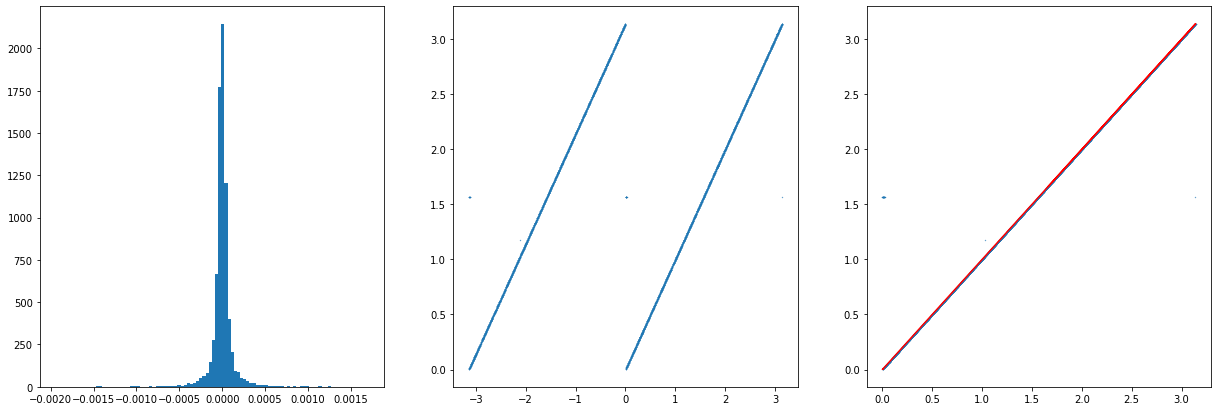

In [214]:
pred2_thetas = 2*np.mod(pred_thetas-np.pi/4,np.pi/2)

fig,ax = plt.subplots(ncols=3,figsize=(21,7))
errs = np.mod(test_theta,np.pi)-pred2_thetas
nice = np.where(np.abs(errs)<0.002)
ax[0].hist(errs[nice],bins=100)
ax[1].scatter(test_theta,pred2_thetas,s=0.1)
ax[2].scatter(np.mod(test_theta,np.pi),pred2_thetas,s=0.1)
ax[2].plot(np.mod(test_theta,np.pi),np.mod(test_theta,np.pi),c='r')

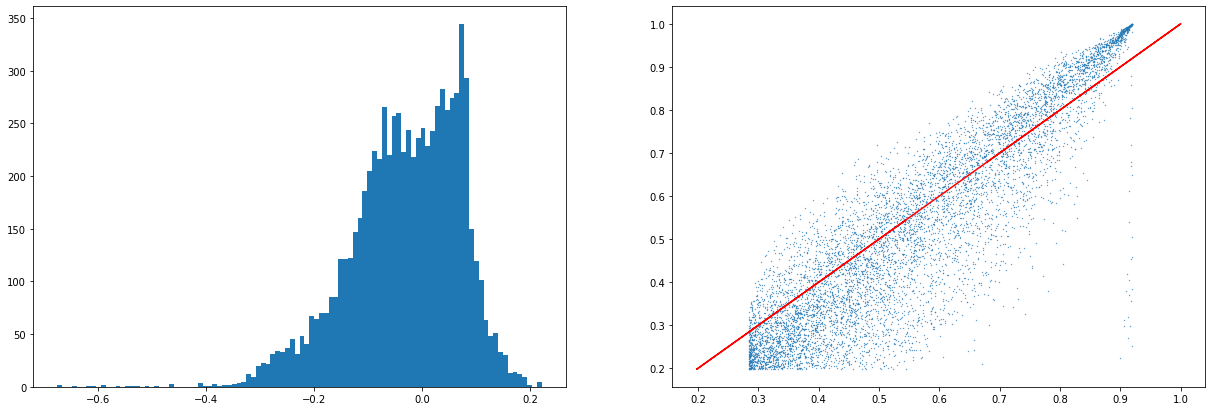

In [220]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
errs = test_ellip-pred2_ellips
ax[0].hist(errs,bins=100)
ax[1].scatter(pred2_ellips,test_ellip,s=0.1)
ax[1].plot(test_ellip,test_ellip,c='r')

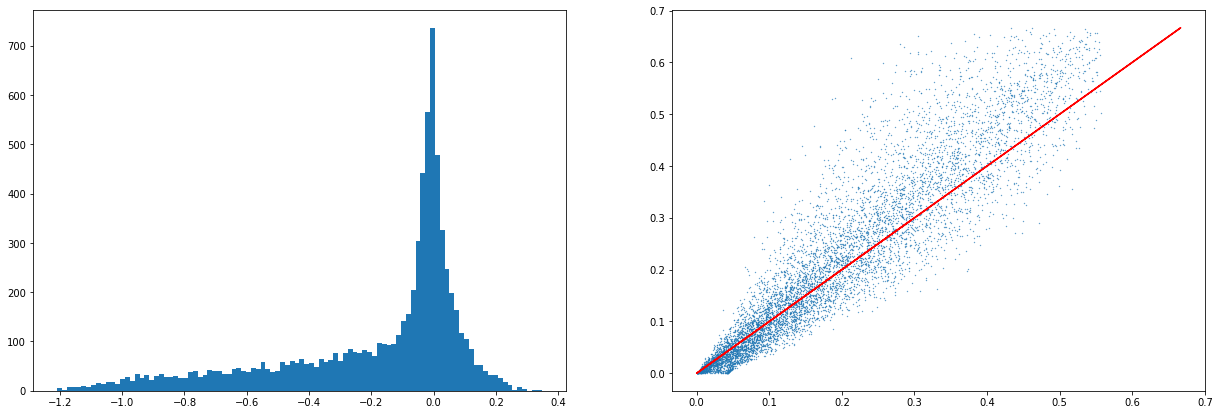

In [224]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
errs = test_g1-pred_g1
ax[0].hist(errs,bins=100)

ax[1].scatter(pred_g1,np.abs(test_g1),s=0.1)
ax[1].plot(np.abs(test_g1),np.abs(test_g1),c='r')

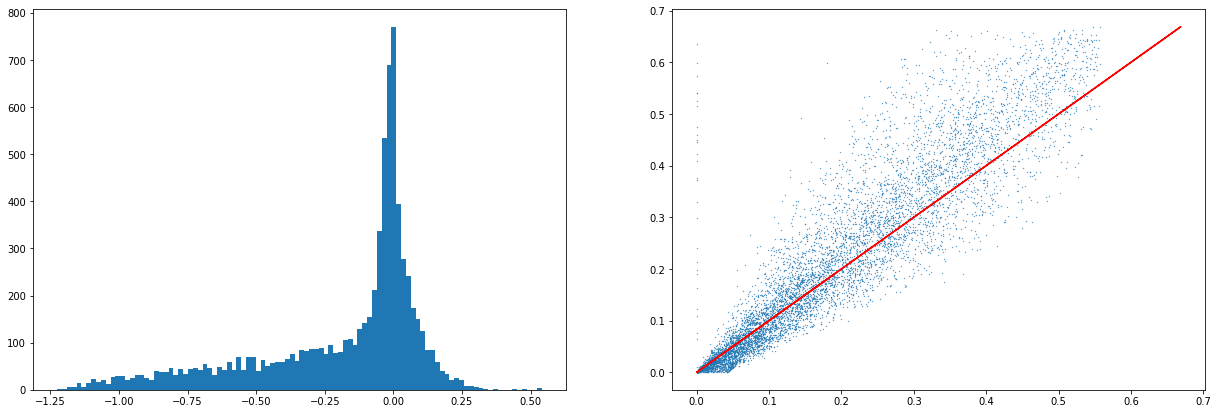

In [230]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
errs = test_g2-pred_g2
ax[0].hist(errs,bins=100)

ax[1].scatter(pred_g2,np.abs(test_g2),s=0.1)
ax[1].plot(np.abs(test_g2),np.abs(test_g2),c='r')

## Lastly lets go for the sersic parameters 

In [260]:
b = lambda n: (2*n-1)/3
def func(r,Ie,n,Re):
    fac = (r/Re)**(1/n)
    return Ie*np.e**(-b(n)*(fac-1))

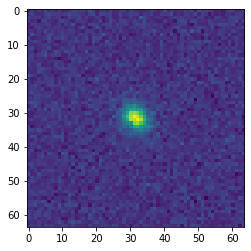

/home/moon/Desktop/CS209b/virutal_environment/cs209b/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


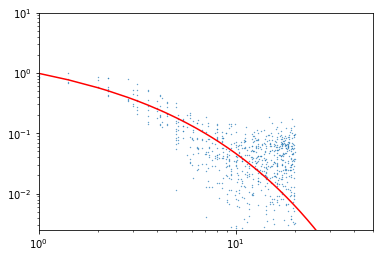

[1.3289148  1.77729534 0.58444555]
[1.32081109 0.64787629 0.18120158 0.11452761 0.57241147]


In [277]:
img = train_noise[0]
plt.imshow(img)
plt.show()

xgrid = np.linspace(0,63,64)
X,Y = np.meshgrid(xgrid,xgrid)

rs = np.sqrt((X-32)**2 + (Y-32)**2).flatten()

args = np.argsort(rs)
rs = rs[args]
vals = img.flatten()[args]
nvals = vals/np.max(vals)

inds = np.where((rs<20)& (rs>0) & (nvals>0))


popt, pcov = curve_fit(func, rs[inds], nvals[inds],maxfev=10000)
plt.scatter(rs[inds],nvals[inds],s=0.1)
plt.plot(rs,func(rs,*popt),c='r')
plt.plot(rs,func(rs,1.0,0.1,0.6),c='g')
plt.yscale('log')
plt.xscale('log')
plt.ylim(2.5e-3,1e1)
plt.xlim(1e0,5e1)

plt.show()


print(popt)
print(label[i])

In [304]:
def get_sersic(img):
    xgrid = np.linspace(0,63,64)
    X,Y = np.meshgrid(xgrid,xgrid)
    rs = np.sqrt((X-32)**2 + (Y-32)**2).flatten()
    vals = img.flatten()
    nvals = vals/np.max(vals)
    #remember to remove the one point where r=0
    inds = np.where((rs<10)& (rs>0) & (nvals>0))
    bounds = [[0,0,0],[2,6,0.6]]
    popt, pcov = curve_fit(func, rs[inds], nvals[inds],bounds=bounds)
    return popt[1:]

In [305]:
#predict on test
out = []
for i in range(len(test_noise)):
    print(i,len(test_noise))
    out.append(get_sersic(train_noise[i]))
out = np.asarray(out)
pred_index = out.T[0]
pred_rad = out.T[1]

0 7666
1 7666
2 7666
3 7666
4 7666
5 7666
6 7666
7 7666
8 7666
9 7666
10 7666
11 7666
12 7666
13 7666
14 7666
15 7666
16 7666
17 7666
18 7666
19 7666
20 7666
21 7666
22 7666
23 7666
24 7666
25 7666
26 7666
27 7666
28 7666
29 7666
30 7666
31 7666
32 7666
33 7666
34 7666
35 7666
36 7666
37 7666
38 7666
39 7666
40 7666
41 7666
42 7666
43 7666
44 7666
45 7666
46 7666
47 7666
48 7666
49 7666
50 7666
51 7666
52 7666
53 7666
54 7666
55 7666
56 7666
57 7666
58 7666
59 7666
60 7666
61 7666
62 7666
63 7666
64 7666
65 7666
66 7666
67 7666
68 7666
69 7666
70 7666
71 7666
72 7666
73 7666
74 7666
75 7666
76 7666
77 7666
78 7666
79 7666
80 7666
81 7666
82 7666
83 7666
84 7666
85 7666
86 7666
87 7666
88 7666
89 7666
90 7666
91 7666
92 7666
93 7666
94 7666
95 7666
96 7666
97 7666
98 7666
99 7666
100 7666
101 7666
102 7666
103 7666
104 7666
105 7666
106 7666
107 7666
108 7666
109 7666
110 7666
111 7666
112 7666
113 7666
114 7666
115 7666
116 7666
117 7666
118 7666
119 7666
120 7666
121 7666
122 7666
123

944 7666
945 7666
946 7666
947 7666
948 7666
949 7666
950 7666
951 7666
952 7666
953 7666
954 7666
955 7666
956 7666
957 7666
958 7666
959 7666
960 7666
961 7666
962 7666
963 7666
964 7666
965 7666
966 7666
967 7666
968 7666
969 7666
970 7666
971 7666
972 7666
973 7666
974 7666
975 7666
976 7666


/home/moon/Desktop/CS209b/virutal_environment/cs209b/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


977 7666
978 7666
979 7666
980 7666
981 7666
982 7666
983 7666
984 7666
985 7666
986 7666
987 7666
988 7666
989 7666
990 7666
991 7666
992 7666
993 7666
994 7666
995 7666
996 7666
997 7666
998 7666
999 7666
1000 7666
1001 7666
1002 7666
1003 7666
1004 7666
1005 7666
1006 7666
1007 7666
1008 7666
1009 7666
1010 7666
1011 7666
1012 7666
1013 7666
1014 7666
1015 7666
1016 7666
1017 7666
1018 7666
1019 7666
1020 7666
1021 7666
1022 7666
1023 7666
1024 7666
1025 7666
1026 7666
1027 7666
1028 7666
1029 7666
1030 7666
1031 7666
1032 7666
1033 7666
1034 7666
1035 7666
1036 7666
1037 7666
1038 7666
1039 7666
1040 7666
1041 7666
1042 7666
1043 7666
1044 7666
1045 7666
1046 7666
1047 7666
1048 7666
1049 7666
1050 7666
1051 7666
1052 7666
1053 7666
1054 7666
1055 7666
1056 7666
1057 7666
1058 7666
1059 7666
1060 7666
1061 7666
1062 7666
1063 7666
1064 7666
1065 7666
1066 7666
1067 7666
1068 7666
1069 7666
1070 7666
1071 7666
1072 7666
1073 7666
1074 7666
1075 7666
1076 7666
1077 7666
1078 7666
107

1811 7666
1812 7666
1813 7666
1814 7666
1815 7666
1816 7666
1817 7666
1818 7666
1819 7666
1820 7666
1821 7666
1822 7666
1823 7666
1824 7666
1825 7666
1826 7666
1827 7666
1828 7666
1829 7666
1830 7666
1831 7666
1832 7666
1833 7666
1834 7666
1835 7666
1836 7666
1837 7666
1838 7666
1839 7666
1840 7666
1841 7666
1842 7666
1843 7666
1844 7666
1845 7666
1846 7666
1847 7666
1848 7666
1849 7666
1850 7666
1851 7666
1852 7666
1853 7666
1854 7666
1855 7666
1856 7666
1857 7666
1858 7666
1859 7666
1860 7666
1861 7666
1862 7666
1863 7666
1864 7666
1865 7666
1866 7666
1867 7666
1868 7666
1869 7666
1870 7666
1871 7666
1872 7666
1873 7666
1874 7666
1875 7666
1876 7666
1877 7666
1878 7666
1879 7666
1880 7666
1881 7666
1882 7666
1883 7666
1884 7666
1885 7666
1886 7666
1887 7666
1888 7666
1889 7666
1890 7666
1891 7666
1892 7666
1893 7666
1894 7666
1895 7666
1896 7666
1897 7666
1898 7666
1899 7666
1900 7666
1901 7666
1902 7666
1903 7666
1904 7666
1905 7666
1906 7666
1907 7666
1908 7666
1909 7666
1910 7666


2651 7666
2652 7666
2653 7666
2654 7666
2655 7666
2656 7666
2657 7666
2658 7666
2659 7666
2660 7666
2661 7666
2662 7666
2663 7666
2664 7666
2665 7666
2666 7666
2667 7666
2668 7666
2669 7666
2670 7666
2671 7666
2672 7666
2673 7666
2674 7666
2675 7666
2676 7666
2677 7666
2678 7666
2679 7666
2680 7666
2681 7666
2682 7666
2683 7666
2684 7666
2685 7666
2686 7666
2687 7666
2688 7666
2689 7666
2690 7666
2691 7666
2692 7666
2693 7666
2694 7666
2695 7666
2696 7666
2697 7666
2698 7666
2699 7666
2700 7666
2701 7666
2702 7666
2703 7666
2704 7666
2705 7666
2706 7666
2707 7666
2708 7666
2709 7666
2710 7666
2711 7666
2712 7666
2713 7666
2714 7666
2715 7666
2716 7666
2717 7666
2718 7666
2719 7666
2720 7666
2721 7666
2722 7666
2723 7666
2724 7666
2725 7666
2726 7666
2727 7666
2728 7666
2729 7666
2730 7666
2731 7666
2732 7666
2733 7666
2734 7666
2735 7666
2736 7666
2737 7666
2738 7666
2739 7666
2740 7666
2741 7666
2742 7666
2743 7666
2744 7666
2745 7666
2746 7666
2747 7666
2748 7666
2749 7666
2750 7666


3480 7666
3481 7666
3482 7666
3483 7666
3484 7666
3485 7666
3486 7666
3487 7666
3488 7666
3489 7666
3490 7666
3491 7666
3492 7666
3493 7666
3494 7666
3495 7666
3496 7666
3497 7666
3498 7666
3499 7666
3500 7666
3501 7666
3502 7666
3503 7666
3504 7666
3505 7666
3506 7666
3507 7666
3508 7666
3509 7666
3510 7666
3511 7666
3512 7666
3513 7666
3514 7666
3515 7666
3516 7666
3517 7666
3518 7666
3519 7666
3520 7666
3521 7666
3522 7666
3523 7666
3524 7666
3525 7666
3526 7666
3527 7666
3528 7666
3529 7666
3530 7666
3531 7666
3532 7666
3533 7666
3534 7666
3535 7666
3536 7666
3537 7666
3538 7666
3539 7666
3540 7666
3541 7666
3542 7666
3543 7666
3544 7666
3545 7666
3546 7666
3547 7666
3548 7666
3549 7666
3550 7666
3551 7666
3552 7666
3553 7666
3554 7666
3555 7666
3556 7666
3557 7666
3558 7666
3559 7666
3560 7666
3561 7666
3562 7666
3563 7666
3564 7666
3565 7666
3566 7666
3567 7666
3568 7666
3569 7666
3570 7666
3571 7666
3572 7666
3573 7666
3574 7666
3575 7666
3576 7666
3577 7666
3578 7666
3579 7666


4332 7666
4333 7666
4334 7666
4335 7666
4336 7666
4337 7666
4338 7666
4339 7666
4340 7666
4341 7666
4342 7666
4343 7666
4344 7666
4345 7666
4346 7666
4347 7666
4348 7666
4349 7666
4350 7666
4351 7666
4352 7666
4353 7666
4354 7666
4355 7666
4356 7666
4357 7666
4358 7666
4359 7666
4360 7666
4361 7666
4362 7666
4363 7666
4364 7666
4365 7666
4366 7666
4367 7666
4368 7666
4369 7666
4370 7666
4371 7666
4372 7666
4373 7666
4374 7666
4375 7666
4376 7666
4377 7666
4378 7666
4379 7666
4380 7666
4381 7666
4382 7666
4383 7666
4384 7666
4385 7666
4386 7666
4387 7666
4388 7666
4389 7666
4390 7666
4391 7666
4392 7666
4393 7666
4394 7666
4395 7666
4396 7666
4397 7666
4398 7666
4399 7666
4400 7666
4401 7666
4402 7666
4403 7666
4404 7666
4405 7666
4406 7666
4407 7666
4408 7666
4409 7666
4410 7666
4411 7666
4412 7666
4413 7666
4414 7666
4415 7666
4416 7666
4417 7666
4418 7666
4419 7666
4420 7666
4421 7666
4422 7666
4423 7666
4424 7666
4425 7666
4426 7666
4427 7666
4428 7666
4429 7666
4430 7666
4431 7666


5172 7666
5173 7666
5174 7666
5175 7666
5176 7666
5177 7666
5178 7666
5179 7666
5180 7666
5181 7666
5182 7666
5183 7666
5184 7666
5185 7666
5186 7666
5187 7666
5188 7666
5189 7666
5190 7666
5191 7666
5192 7666
5193 7666
5194 7666
5195 7666
5196 7666
5197 7666
5198 7666
5199 7666
5200 7666
5201 7666
5202 7666
5203 7666
5204 7666
5205 7666
5206 7666
5207 7666
5208 7666
5209 7666
5210 7666
5211 7666
5212 7666
5213 7666
5214 7666
5215 7666
5216 7666
5217 7666
5218 7666
5219 7666
5220 7666
5221 7666
5222 7666
5223 7666
5224 7666
5225 7666
5226 7666
5227 7666
5228 7666
5229 7666
5230 7666
5231 7666
5232 7666
5233 7666
5234 7666
5235 7666
5236 7666
5237 7666
5238 7666
5239 7666
5240 7666
5241 7666
5242 7666
5243 7666
5244 7666
5245 7666
5246 7666
5247 7666
5248 7666
5249 7666
5250 7666
5251 7666
5252 7666
5253 7666
5254 7666
5255 7666
5256 7666
5257 7666
5258 7666
5259 7666
5260 7666
5261 7666
5262 7666
5263 7666
5264 7666
5265 7666
5266 7666
5267 7666
5268 7666
5269 7666
5270 7666
5271 7666


6006 7666
6007 7666
6008 7666
6009 7666
6010 7666
6011 7666
6012 7666
6013 7666
6014 7666
6015 7666
6016 7666
6017 7666
6018 7666
6019 7666
6020 7666
6021 7666
6022 7666
6023 7666
6024 7666
6025 7666
6026 7666
6027 7666
6028 7666
6029 7666
6030 7666
6031 7666
6032 7666
6033 7666
6034 7666
6035 7666
6036 7666
6037 7666
6038 7666
6039 7666
6040 7666
6041 7666
6042 7666
6043 7666
6044 7666
6045 7666
6046 7666
6047 7666
6048 7666
6049 7666
6050 7666
6051 7666
6052 7666
6053 7666
6054 7666
6055 7666
6056 7666
6057 7666
6058 7666
6059 7666
6060 7666
6061 7666
6062 7666
6063 7666
6064 7666
6065 7666
6066 7666
6067 7666
6068 7666
6069 7666
6070 7666
6071 7666
6072 7666
6073 7666
6074 7666
6075 7666
6076 7666
6077 7666
6078 7666
6079 7666
6080 7666
6081 7666
6082 7666
6083 7666
6084 7666
6085 7666
6086 7666
6087 7666
6088 7666
6089 7666
6090 7666
6091 7666
6092 7666
6093 7666
6094 7666
6095 7666
6096 7666
6097 7666
6098 7666
6099 7666
6100 7666
6101 7666
6102 7666
6103 7666
6104 7666
6105 7666


6830 7666
6831 7666
6832 7666
6833 7666
6834 7666
6835 7666
6836 7666
6837 7666
6838 7666
6839 7666
6840 7666
6841 7666
6842 7666
6843 7666
6844 7666
6845 7666
6846 7666
6847 7666
6848 7666
6849 7666
6850 7666
6851 7666
6852 7666
6853 7666
6854 7666
6855 7666
6856 7666
6857 7666
6858 7666
6859 7666
6860 7666
6861 7666
6862 7666
6863 7666
6864 7666
6865 7666
6866 7666
6867 7666
6868 7666
6869 7666
6870 7666
6871 7666
6872 7666
6873 7666
6874 7666
6875 7666
6876 7666
6877 7666
6878 7666
6879 7666
6880 7666
6881 7666
6882 7666
6883 7666
6884 7666
6885 7666
6886 7666
6887 7666
6888 7666
6889 7666
6890 7666
6891 7666
6892 7666
6893 7666
6894 7666
6895 7666
6896 7666
6897 7666
6898 7666
6899 7666
6900 7666
6901 7666
6902 7666
6903 7666
6904 7666
6905 7666
6906 7666
6907 7666
6908 7666
6909 7666
6910 7666
6911 7666
6912 7666
6913 7666
6914 7666
6915 7666
6916 7666
6917 7666
6918 7666
6919 7666
6920 7666
6921 7666
6922 7666
6923 7666
6924 7666
6925 7666
6926 7666
6927 7666
6928 7666
6929 7666


7651 7666
7652 7666
7653 7666
7654 7666
7655 7666
7656 7666
7657 7666
7658 7666
7659 7666
7660 7666
7661 7666
7662 7666
7663 7666
7664 7666
7665 7666


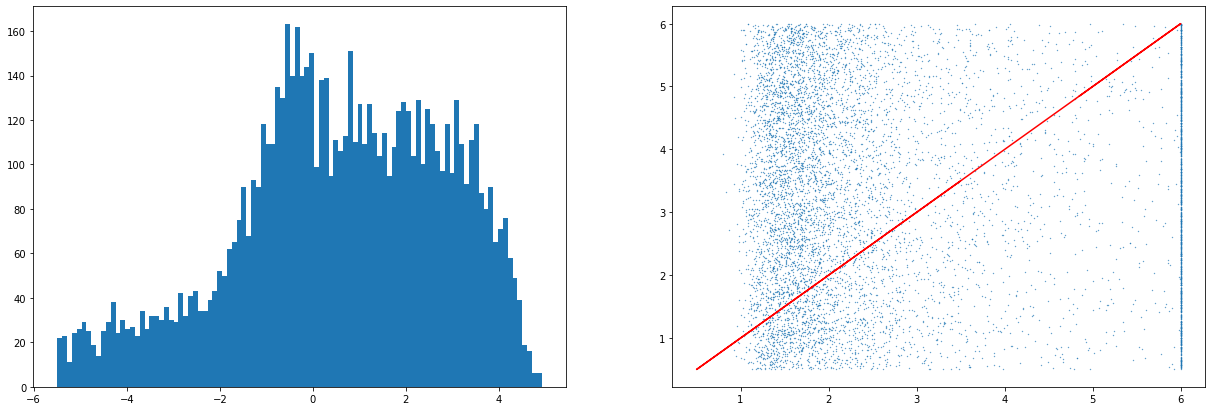

In [306]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
errs = test_index-pred_index
ax[0].hist(errs,bins=100)

ax[1].scatter(pred_index,test_index,s=0.1)
ax[1].plot(test_index,test_index,c='r')

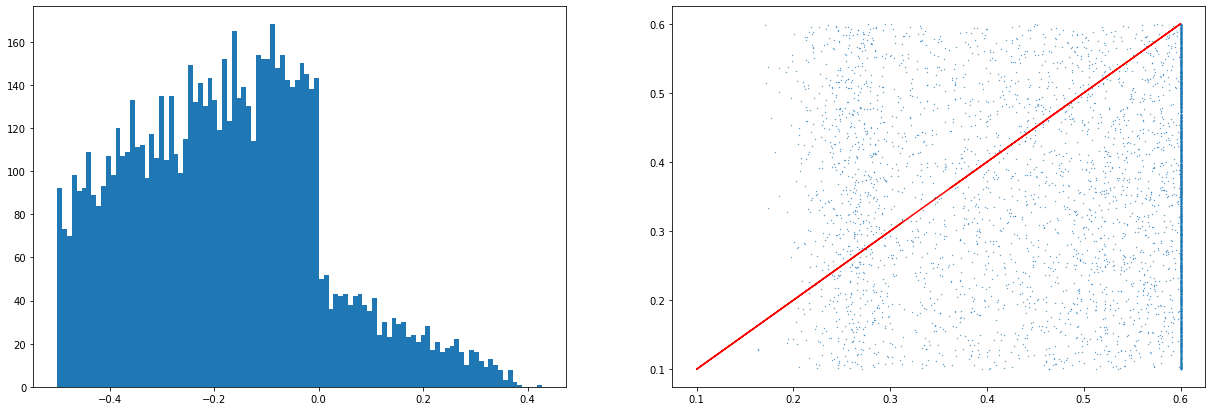

In [307]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
errs = test_rad-pred_rad
ax[0].hist(errs,bins=100)

ax[1].scatter(pred_rad,test_rad,s=0.1)
ax[1].plot(test_rad,test_rad,c='r')

In [ ]:
test_flux = test_label[:,0]
test_index = test_label[:,1]
test_rad = test_label[:,2]
test_g1 = test_label[:,3]
test_g2 = test_label[:,4]

In [311]:
flux = np.asarray([test_flux,pred_flux])
index = np.asarray([test_index,pred_index])
rad = np.asarray([test_rad,pred_rad])
g1 = np.asarray([test_g1,pred_g1])
g2 = np.asarray([test_g2,pred_g2])

In [312]:
np.save('flux',flux)
np.save('index',index)
np.save('rad',rad)
np.save('g1',g1)
np.save('g2',g2)